# Homework 3 Problem1: 針對不平衡資料的單光子電腦斷層掃描影像多類別分類方法

在HW3的第一個問題中，以下的 TODO 需要在 notebook 中完成：

- **接續 HW2**

1. 調整適當的超參數

2. 完成 Dataset 中 mode = valid、test 的 getitem()

3. 將 validation 空白處填起來讓程式能夠運作 

4. 調整適當的 optimizer、scheduler

5. 填寫 test_dataset、test_loader、model 三個空格。

6. 將你認為最好的預測結果輸出成 ResNet50_6c.csv

- **HW3 主要的部分**

1. 在 Data Transformation 中嘗試使用image augmentatiion

2. Redefine a Resnet50 model

3. 練習以不同的方式（Random Oversampling 或 Weighted Loss Function）來解決資料不平衡的問題

In [1]:
!pip install torchsummary

In [2]:
import pydicom
import pandas as pd
import numpy as np
import os
import random
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import plotly.express as px

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, Subset, DataLoader
from torchvision.transforms import v2
import torchvision.transforms as transforms
import torchvision.models as models # VGG16, ResNet50
from torchsummary import summary # summary for models
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import RandomOverSampler

import gc
import cv2

import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

In [3]:
new_data = pd.read_csv("/kaggle/input/deeplearninghw3/train_hwk02_new.csv")

In [4]:
new_data_label_dist = new_data.iloc[:,5].value_counts().sort_index()
new_data_label_dist = pd.DataFrame(
    {
        "label" : new_data_label_dist.index.astype(str),
        "number of samples" : new_data_label_dist.values
    }
)

In [5]:
print(new_data.head())

        ID  Age  Gender                 FilePath  index  Stage_New
0  A175204   69       0  /DICOM/A175204/00010018      7          2
1  A122221   56       0  /DICOM/A122221/00010034     15          1
2   A54671   82       0   /DICOM/A54671/00010021      8          1
3   A31117   71       1   /DICOM/A31117/00010022     10          2
4  A653195   68       0  /DICOM/A653195/00010016      7          2


In [6]:
new_data_label_dist

,label,number of samples
0,0,4
1,1,17
2,2,23
3,3,42
4,4,69
5,5,6


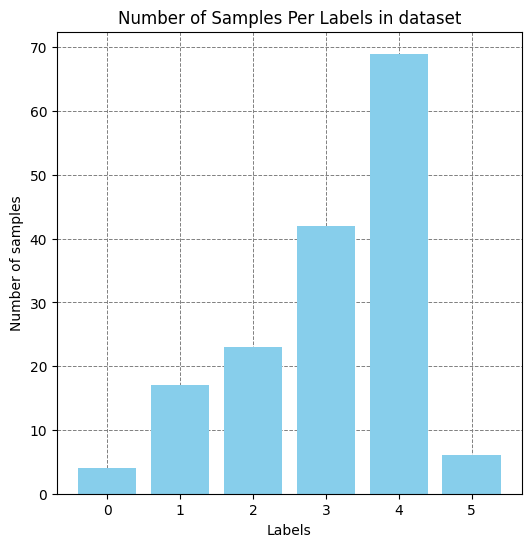

In [7]:
from matplotlib.ticker import MaxNLocator

labels, counts = new_data_label_dist["label"], new_data_label_dist["number of samples"]

plt.figure(figsize = (6, 6))

# 設定 zorder 為 2，讓長條圖在網格線上面顯示
plt.bar(labels, counts, color = 'skyblue', zorder = 2)

plt.xlabel('Labels')
plt.ylabel("Number of samples")
plt.title("Number of Samples Per Labels in dataset")

# 設定 x 軸為整數
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.grid(True, which = 'both', axis = 'both', linestyle = '--', color='gray', linewidth = 0.7, zorder = 1)


# 顯示圖表
plt.show()

# Imbalance preprocessing

1. Random Oversampling

2. Weight Loss Function

In [9]:
n = new_data.shape[0]
train_ids, valid_ids = train_test_split(
    np.linspace(0, n-1, n).astype(int),
    test_size = 0.2,
    random_state = 42,
    stratify = new_data.Stage_New
)

In [10]:
print(f"There are {len(train_ids)} samples in training set.")
print(f"There are {len(valid_ids)} samples in validation set.")

There are 128 samples in training set.
There are 33 samples in validation set.


In [11]:
train_data = new_data.iloc[train_ids]
print(train_data["Stage_New"].value_counts().sort_index())

Stage_New
0     3
1    14
2    18
3    33
4    55
5     5
Name: count, dtype: int64


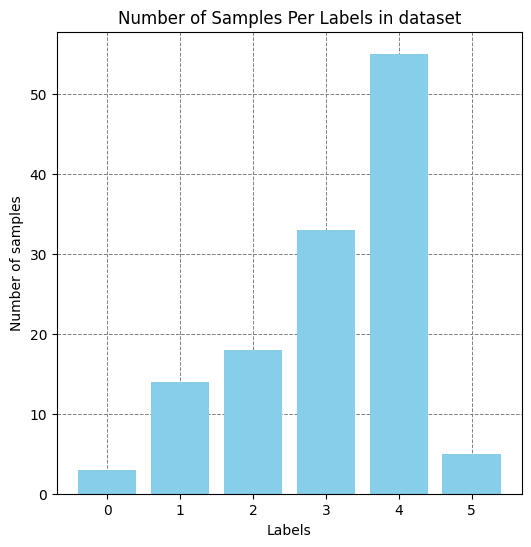

In [12]:
train_label_dict = train_data["Stage_New"].value_counts().sort_index()
train_label_dict = pd.DataFrame(
    {
        "label" : train_label_dict.index.astype(str),
        "number of samples" : train_label_dict.values
    }
)

labels, counts = train_label_dict["label"], train_label_dict["number of samples"]

plt.figure(figsize = (6, 6))

# 設定 zorder 為 2，讓長條圖在網格線上面顯示
plt.bar(labels, counts, color = 'skyblue', zorder = 2)

plt.xlabel('Labels')
plt.ylabel("Number of samples")
plt.title("Number of Samples Per Labels in dataset")

# 設定 x 軸為整數
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.grid(True, which = 'both', axis = 'both', linestyle = '--', color='gray', linewidth = 0.7, zorder = 1)


# 顯示圖表
plt.show()

## Random Oversampling

In [13]:
from imblearn.over_sampling import RandomOverSampler

In [14]:
oversampler = RandomOverSampler(random_state = 42)
train_data_ros_X, train_data_ros_y = oversampler.fit_resample(train_data.iloc[:, 1:5], train_data.iloc[:, 5])
train_data_ros = pd.concat([train_data_ros_X, train_data_ros_y], axis = 1)

In [15]:
train_data_ros["Stage_New"].value_counts().sort_index()

Stage_New
0    55
1    55
2    55
3    55
4    55
5    55
Name: count, dtype: int64

## Weighted Loss Function

透過調整每個類別的權重來平衡損失函數中不同類別的影響，數量越少的類別權重越高，反之則越低。

In [16]:
# 計算 train_data["Stage_New"] 中每個類別的樣本數量，並且依照類別索引順序排列，最後存為一個列表 class_num
class_num = [item for item in train_data["Stage_New"].value_counts().sort_index()]
print("class_num: ", class_num)

# 使用所有訓練樣本數量 len(train_ids) 除以 class_num 中每個類別的樣本數量，以此來計算每個類別的權重。
# 樣本數量少的類別會得到比較高的權重，而樣本數量多的類別會得到較低的權重。
class_weight = len(train_ids) / torch.FloatTensor(class_num)
print("\nclass_weight: ", class_weight)

# 將 class_weight 正規化，讓所有權重的總和為 1
class_weight = class_weight / class_weight.sum()
print("\nclass_weight: ", class_weight)

class_num:  [3, 14, 18, 33, 55, 5]

class_weight:  tensor([42.6667,  9.1429,  7.1111,  3.8788,  2.3273, 25.6000])

class_weight:  tensor([0.4703, 0.1008, 0.0784, 0.0428, 0.0257, 0.2822])


在Pytorch 中，我們通常使用 `nn.CrossEntropyLoss()` 作為我們的 criterion 來計算損失函數，如果在函數中加入一個 `weight` 參數，便可以對不同類別指定權重。

* code:

`criterion = nn.CrossEntropyLoss(weight = class_weight)`

---


# Problem 1

## Configuration

In [17]:
# TODO: 調整適當的超參數
class config:
    
    root = "/kaggle/input/deeplearninghw3"
    num_classes = 6
    valid_prob = 0.2
    batch_size = 16
    epochs = 50
    lr = 1e-5
    weight_decay = 1e-4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42
    
print(config.device)

cuda


In [18]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False 

## Defined Dataset

In [19]:
class ParkinsonsDataset(torch.utils.data.Dataset):
    def __init__(self, df, mode = None, transforms = None):
        
        self.df = df
        self.mode = mode
        self.transforms = transforms

    def __getitem__(self, x): # 找出指定的資料
        
        age = torch.tensor(self.df.iloc[x, 1]) # 年齡
        gender = torch.tensor(self.df.iloc[x, 2]) # 性別
        index = torch.tensor(self.df.iloc[x, 4]) # 起始張數
        
        # 影像前處理
        image = pydicom.dcmread(config.root + self.df.iloc[x, 3]).pixel_array
        image = torch.tensor(image.astype(np.float32))
        image = image[index-1:index+2, :, :]

        if self.mode == "train":
            label = torch.tensor(self.df.iloc[x, 5])
            if self.transforms: image = self.transforms(image)

            return image, age, gender, label
        
        # TODO: 和HW2作法一樣，寫出當 mode = valid、test 的 getitem() 
        elif self.mode == "valid":
            label = torch.tensor(self.df.iloc[x, 5]) # 標籤
            if self.transforms: image = self.transforms(image)
            return image, age, gender, label
    
        elif self.mode == "test":
            if self.transforms: image = self.transforms(image)
            return image, age, gender

        
    def __len__(self):
        return self.df.shape[0]

## Data Transformation

In [20]:
# Transformation
class Normalization(object): # 自定義的類別

    def __call__(self, image): # 定義有image之後要進行的資料處理
        new_image = (image - image.min())/(image.max() - image.min())

        return new_image
    
def build_transform(is_train):
    t = []
    if is_train:       
        t.append(v2.CenterCrop(size = (50, 50)))
        t.append(Normalization())
        
# TODO: 試著使用 image augmentation，調整過程中會發現結果可能變好也可能變壞，選擇適當的 transform。
# 範例如下
        t.append(v2.RandomRotation(30, interpolation = 2))
        t.append(v2.RandomHorizontalFlip(p = 0.25))
        return v2.Compose(t)

    t.append(v2.CenterCrop(size = (50, 50)))
    t.append(Normalization())
    return v2.Compose(t)

## Evaluator

In [21]:
def evaluator(preds, gts):
    preds = preds.cpu().numpy() if isinstance(preds, torch.Tensor) else preds
    gts = gts.cpu().numpy() if isinstance(gts, torch.Tensor) else gts
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts, average = "macro")
    misclassification_rate = 1 - acc
    
    return acc, f1, misclassification_rate

## Training

In [22]:
def train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device):
    model.train() 
    
    train_loss = .0
    predictions, ground_truths = [], []
    
    for images, ages, genders, labels in train_loader:
        images = images.to(device = device, dtype = torch.float)
        ages = ages.to(device = device, dtype = torch.float)
        genders = genders.to(device = device, dtype = torch.float)
        labels = labels.to(device = device, dtype = torch.long)

        optimizer.zero_grad()
        logits = model(images, ages, genders)
        
        loss = criterion(logits, labels)
        loss.backward()

        optimizer.step()

        train_loss += loss.item()
        preds = torch.argmax(logits, dim = 1)

        predictions.append(preds)
        ground_truths.append(labels)
    
    scheduler.step()
    
    train_loss /= len(train_loader)

    predictions = torch.cat(predictions)
    ground_truths = torch.cat(ground_truths)
    train_acc, train_f1, train_misclass = evaluator(predictions, ground_truths)

    return train_loss, 100*train_acc, 100*train_f1, 100*train_misclass

## Validation

In [23]:
# TODO: 將 validation 空白處填起來讓程式能夠運作
def validation(model, valid_loader, criterion, device):
    model.eval()
    valid_loss = .0
    predictions, ground_truths = [], []
    
    with torch.no_grad():
        for images, ages, genders, labels in valid_loader:
            images = images.to(device=device, dtype=torch.float)
            ages = ages.to(device=device, dtype=torch.float)
            genders = genders.to(device=device, dtype=torch.float)
            labels = labels.to(device=device, dtype=torch.long)

            logits = model(images, ages, genders)
            loss = criterion(logits, labels) 

            valid_loss += loss.item()
            preds = torch.argmax(logits, dim = 1)

            predictions.append(preds)
            ground_truths.append(labels)

        valid_loss /= len(valid_loader)

        predictions = torch.cat(predictions)
        ground_truths = torch.cat(ground_truths) 
        valid_acc, valid_f1, valid_misclass = evaluator(predictions, ground_truths)
        
    return valid_loss, 100*valid_acc, 100*valid_f1, 100*valid_misclass

## Model

In [24]:
# TODO: Redefine a Resnet50 model（照 HW2 的做法）
class ResNet50plus(nn.Module):
    def __init__(self, num_classes, input_size=(3, 50, 50), features_grad=False):
        super().__init__()
        
        # 本次作業指定使用Resnet50進行修改
        resnet50 = models.resnet50(weights = "IMAGENET1K_V1", progress = True)
        # Replace the final fully connected layer with an identity layer
        resnet50.fc = nn.Identity()
        
        # Freeze layers based on features_grad parameter
        for param in resnet50.parameters():
            param.requires_grad = features_grad
        self.backend = resnet50
        
        # Add a custom classifier that includes age and gender inputs
        self.classifier = nn.Sequential(
            nn.Linear(2048 + 2, num_classes)  # 2048: ResNet-50 output features, 2: age & gender
        )

    def forward(self, x, age, gender):
        # Extract features from ResNet-50 backbone
        output = self.backend(x)  # output shape: (batch_size, 2048)
        
        # Concatenate age and gender features
        outputs = torch.cat([output, age.view(-1, 1), gender.view(-1, 1)], dim=1)
        
        # Classify the combined features
        outputs = self.classifier(outputs)
        return outputs

In [25]:
model = ResNet50plus(num_classes = 6)
total_params = sum(p.numel() for p in model.parameters())
print("總參數量:", total_params)
del model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 154MB/s] 


總參數量: 23520338


## main

TODO: 練習以不同的方式（Random Oversampling 或 Weighted Loss Function）來解決資料不平衡的問題 

**最後採用一種方式作為繳交的 main function 即可**

Initializing dataset...
nuumber of class before random oversampling: [3, 14, 18, 33, 55, 5]
nuumber of class after random oversampling: [55, 55, 55, 55, 55, 55]
Initializing model...
Epoch[1/50], Train Loss: 2.1155, Train Accuracy: 16.06%, Train F1: 9.81% | Valid Loss: 2.5796, Valid Accuracy: 3.03%, Valid F1: 1.08% | LR: 0.000000
Epoch[2/50], Train Loss: 2.1123, Train Accuracy: 17.88%, Train F1: 10.15% | Valid Loss: 2.3158, Valid Accuracy: 3.03%, Valid F1: 3.03% | LR: 0.000000
Epoch[3/50], Train Loss: 2.1029, Train Accuracy: 17.27%, Train F1: 10.08% | Valid Loss: 2.2456, Valid Accuracy: 3.03%, Valid F1: 1.19% | LR: 0.000000
Epoch[4/50], Train Loss: 2.0672, Train Accuracy: 18.79%, Train F1: 10.98% | Valid Loss: 2.3034, Valid Accuracy: 3.03%, Valid F1: 1.33% | LR: 0.000000
Epoch[5/50], Train Loss: 2.0749, Train Accuracy: 17.58%, Train F1: 10.26% | Valid Loss: 2.3207, Valid Accuracy: 3.03%, Valid F1: 1.33% | LR: 0.000000
Epoch[6/50], Train Loss: 2.0740, Train Accuracy: 17.58%, Train F1: 1

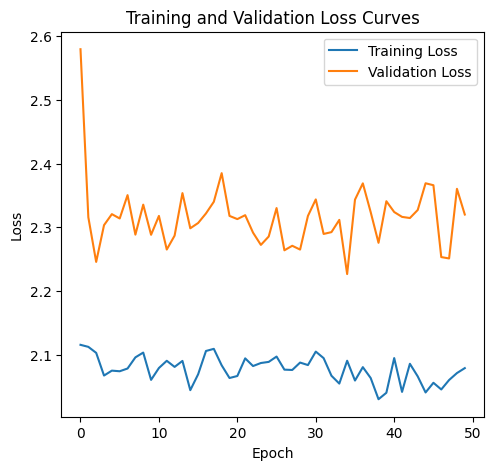

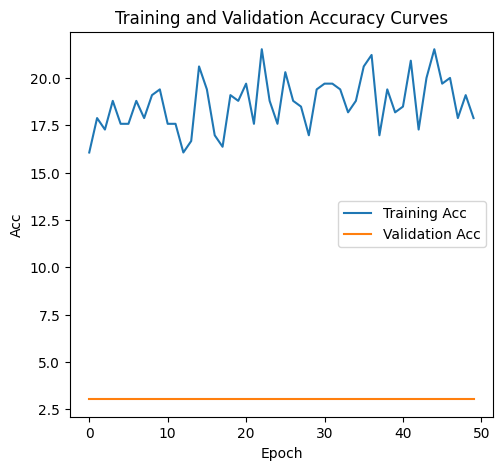

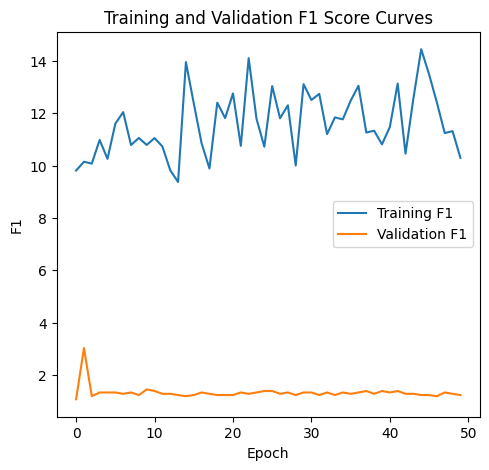

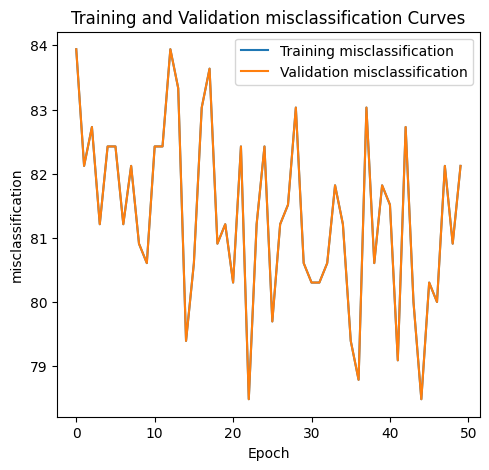

**********  Validation  **********
Valid Loss: 2.2266, Valid Accuracy: 3.03%, Valid F1: 1.33%


In [26]:
# 以下是採用 random oversampling 的範例
def main():

    seed_everything(config.seed)

    # Dataset
    print("Initializing dataset...")
    new_data = pd.read_csv(os.path.join(config.root, 'train_hwk02_new.csv'))

    # split training & validation dataset
    # stratify = new_data.Stage_New: 面對資料不平衡的情況，先按照label比例去切分資料集
    n = new_data.shape[0]    
    train_ids , valid_ids = train_test_split(
        np.linspace(0, n - 1, n).astype("int"),
        test_size = 0.2,
        random_state = config.seed,
        stratify = new_data.Stage_New
    )
    train_data = new_data.iloc[train_ids]
    valid_data = new_data.iloc[valid_ids]
    
    num_class = [num for num in train_data.iloc[:, 5].value_counts().sort_index()]
    print(f"nuumber of class before random oversampling: {num_class}")
    
    # 進行random oversampling
    oversampler = RandomOverSampler(random_state = 42)
    train_data_ros_X, train_data_ros_y = oversampler.fit_resample(train_data.iloc[:, 0:5], train_data.iloc[:, 5])
    train_data_ros = pd.concat([train_data_ros_X, train_data_ros_y], axis = 1) 
    num_class = [num for num in train_data_ros.iloc[:, 5].value_counts().sort_index()]
    print(f"nuumber of class after random oversampling: {num_class}")
    
    train_dataset = ParkinsonsDataset(train_data_ros, mode = "train", transforms = build_transform(True))
    valid_dataset = ParkinsonsDataset(valid_data, mode = "valid", transforms = build_transform(False))
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=config.batch_size, shuffle=False)
    
    
    # settings
    print("Initializing model...")
    model = ResNet50plus(num_classes = config.num_classes, features_grad = True)
    model.to(config.device)
    criterion = nn.CrossEntropyLoss().to(config.device)
    parameters = [p for p in model.parameters() if p.requires_grad] 
    
    # TODO: 調整適當的 optimizer、scheduler，確認自己的 scheduler 是以 epoch 還是 batch 為單位更新學習率
    optimizer = torch.optim.Adam(model.parameters(), lr = config.lr, weight_decay = config.weight_decay)
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 12, gamma = 0.1)
    # 參考網站: https://pytorch.org/docs/stable/optim.html
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer = optimizer,
        epochs = config.epochs,
        steps_per_epoch = train_loader.__len__(),
        max_lr = config.lr,
        anneal_strategy = 'cos'
    )

    # recordings
    best_val_loss = float("inf")
    history = {
      "train": {
          "loss": [],
          "acc": [],
          "f1": [],
          "misclass": []
      },
      "valid": {
          "loss": [],
          "acc": [],
          "f1": [],
          "misclass": []
      },
    }

    for epoch in range(config.epochs):
        train_loss, train_acc, train_f1 , train_misclass = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, config.device)
        valid_loss, valid_acc, valid_f1 , valid_misclass = validation(model, valid_loader, criterion, config.device)

        # Log the loss and validation result
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["train"]["misclass"].append(train_misclass)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)
        history["valid"]["misclass"].append(train_misclass)

        print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')

        if valid_loss < best_val_loss:
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, "checkpoint.pth")

        best_ckpt = torch.load("checkpoint.pth", map_location=config.device, weights_only=False)
        model.load_state_dict(best_ckpt["model"])

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss"], label='Training Loss')
    plt.plot(range(config.epochs), history["valid"]["loss"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["acc"], label='Training Acc')
    plt.plot(range(config.epochs), history["valid"]["acc"], label='Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["f1"], label='Training F1')
    plt.plot(range(config.epochs), history["valid"]["f1"], label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.legend()
    plt.title('Training and Validation F1 Score Curves')
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["misclass"], label='Training misclassification')
    plt.plot(range(config.epochs), history["valid"]["misclass"], label='Validation misclassification')
    plt.xlabel('Epoch')
    plt.ylabel('misclassification')
    plt.legend()
    plt.title('Training and Validation misclassification Curves')
    plt.show()
    
    best_ckpt = torch.load(f"checkpoint.pth", map_location=config.device, weights_only=False)
    model.load_state_dict(best_ckpt["model"])
    
    valid_loss, valid_acc, valid_f1, valid_misclass = validation(model, valid_loader, criterion, config.device)
    print("*"*10, " Validation ", "*"*10)
    print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}%")

if __name__ == "__main__":
    main()

Initializing dataset...
Initializing model...
Epoch[1/50], Train Loss: 2.1560, Train Accuracy: 3.91%, Train F1: 3.52% | Valid Loss: 2.2921, Valid Accuracy: 6.06%, Valid F1: 5.40% | LR: 0.000010
Epoch[2/50], Train Loss: 2.1226, Train Accuracy: 2.34%, Train F1: 3.02% | Valid Loss: 2.2558, Valid Accuracy: 3.03%, Valid F1: 1.19% | LR: 0.000010
Epoch[3/50], Train Loss: 2.0107, Train Accuracy: 10.94%, Train F1: 12.48% | Valid Loss: 2.1457, Valid Accuracy: 0.00%, Valid F1: 0.00% | LR: 0.000010
Epoch[4/50], Train Loss: 2.0232, Train Accuracy: 6.25%, Train F1: 6.82% | Valid Loss: 1.9070, Valid Accuracy: 3.03%, Valid F1: 1.59% | LR: 0.000010
Epoch[5/50], Train Loss: 1.9143, Train Accuracy: 7.81%, Train F1: 8.32% | Valid Loss: 1.9376, Valid Accuracy: 3.03%, Valid F1: 1.96% | LR: 0.000010
Epoch[6/50], Train Loss: 1.9198, Train Accuracy: 8.59%, Train F1: 9.60% | Valid Loss: 1.9093, Valid Accuracy: 3.03%, Valid F1: 2.78% | LR: 0.000010
Epoch[7/50], Train Loss: 1.8358, Train Accuracy: 7.81%, Train F1

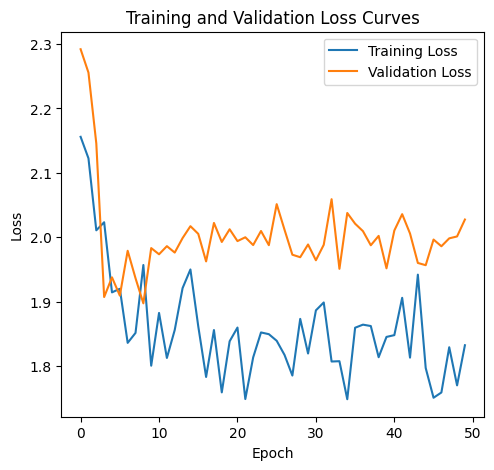

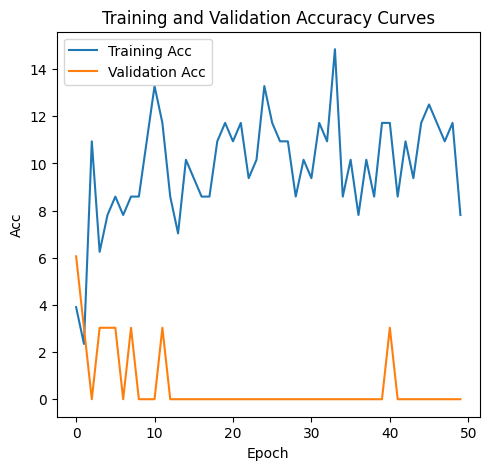

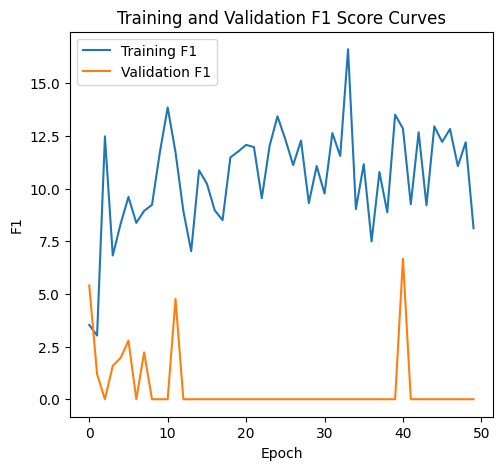

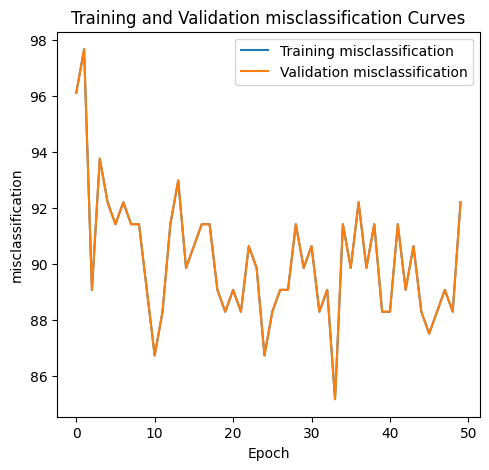

**********  Validation  **********
Valid Loss: 1.8972, Valid Accuracy: 0.00%, Valid F1: 0.00%


In [27]:
from sklearn.utils.class_weight import compute_class_weight
# 練習使用 weighted loss function 的方法
def main():

    seed_everything(config.seed)

    # Dataset
    print("Initializing dataset...")
    new_data = pd.read_csv(os.path.join(config.root, 'train_hwk02_new.csv'))

    # split training & validation dataset
    # stratify = new_data.Stage_New: 面對資料不平衡的情況，先按照label比例去切分資料集
    n = new_data.shape[0]    
    train_ids , valid_ids = train_test_split(
        np.linspace(0, n - 1, n).astype("int"),
        test_size = 0.2,
        random_state = config.seed,
        stratify = new_data.Stage_New
    )
    train_data = new_data.iloc[train_ids]
    valid_data = new_data.iloc[valid_ids]
    train_dataset = ParkinsonsDataset(train_data, mode = "train", transforms = build_transform(True))
    valid_dataset = ParkinsonsDataset(valid_data, mode = "valid", transforms = build_transform(False))
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=config.batch_size, shuffle=False)
    
    # TODO: 試著完成後面的部分
    # 計算 train_data["Stage_New"] 中每個類別的樣本數量，並且依照類別索引順序排列，最後存為一個列表 class_num
    class_num = [item for item in train_data["Stage_New"].value_counts().sort_index()]
    
    # 使用所有訓練樣本數量 len(train_ids) 除以 class_num 中每個類別的樣本數量，以此來計算每個類別的權重。
    # 樣本數量少的類別會得到比較高的權重，而樣本數量多的類別會得到較低的權重。
    class_weight = len(train_ids) / torch.FloatTensor(class_num)
    class_weight = class_weight / class_weight.sum()
    
    # settings
    print("Initializing model...")
    model = ResNet50plus(num_classes = config.num_classes, features_grad = True)
    model.to(config.device)
    criterion = nn.CrossEntropyLoss(weight=class_weight).to(config.device)
    parameters = [p for p in model.parameters() if p.requires_grad] 
    
    # TODO: 調整適當的 optimizer、scheduler，確認自己的 scheduler 是以 epoch 還是 batch 為單位更新學習率
    optimizer = torch.optim.Adam(model.parameters(), lr = config.lr, weight_decay = config.weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 12, gamma = 0.1)
    # 參考網站: https://pytorch.org/docs/stable/optim.html

    # recordings
    best_val_loss = float("inf")
    history = {
      "train": {
          "loss": [],
          "acc": [],
          "f1": [],
          "misclass": []
      },
      "valid": {
          "loss": [],
          "acc": [],
          "f1": [],
          "misclass": []
      },
    }

    for epoch in range(config.epochs):
        train_loss, train_acc, train_f1 , train_misclass = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, config.device)
        valid_loss, valid_acc, valid_f1 , valid_misclass = validation(model, valid_loader, criterion, config.device)

        # Log the loss and validation result
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["train"]["misclass"].append(train_misclass)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)
        history["valid"]["misclass"].append(train_misclass)

        print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')

        if valid_loss < best_val_loss:
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, "checkpoint2.pth")

        best_ckpt = torch.load("checkpoint2.pth", map_location=config.device, weights_only=False)
        model.load_state_dict(best_ckpt["model"])

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss"], label='Training Loss')
    plt.plot(range(config.epochs), history["valid"]["loss"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["acc"], label='Training Acc')
    plt.plot(range(config.epochs), history["valid"]["acc"], label='Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["f1"], label='Training F1')
    plt.plot(range(config.epochs), history["valid"]["f1"], label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.legend()
    plt.title('Training and Validation F1 Score Curves')
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["misclass"], label='Training misclassification')
    plt.plot(range(config.epochs), history["valid"]["misclass"], label='Validation misclassification')
    plt.xlabel('Epoch')
    plt.ylabel('misclassification')
    plt.legend()
    plt.title('Training and Validation misclassification Curves')
    plt.show()
    
    best_ckpt = torch.load(f"checkpoint2.pth", map_location=config.device, weights_only=False)
    model.load_state_dict(best_ckpt["model"])
    
    valid_loss, valid_acc, valid_f1, valid_misclass = validation(model, valid_loader, criterion, config.device)
    print("*"*10, " Validation ", "*"*10)
    print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}%")

if __name__ == "__main__":
    main()

## Testing

In [28]:
def testing(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad(): 
        for image, age, gender in test_loader:
            image = image.to(device = device, dtype = torch.float)
            age = age.to(device)
            gender = gender.to(device)
            logits = model(image, age, gender)
            pred = torch.argmax(logits, dim = 1)
            preds.append(pred)

    preds = torch.cat(preds)
    
    return preds

In [29]:
seed_everything(config.seed)
test_data = pd.read_csv(os.path.join(config.root, 'test.csv'))

# TODO: 填寫 test_dataset、test_loader、model 三個空格，記得 test_loader 的 shuffle = False。

test_dataset = ParkinsonsDataset(test_data, transforms = build_transform(False), mode = "test")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = config.batch_size, shuffle = False)
model = ResNet50plus(num_classes = config.num_classes)

model.to(config.device)

best_ckpt = torch.load(f"checkpoint.pth")
model.load_state_dict(best_ckpt["model"])

preds = testing(model, test_loader, config.device)

In [30]:
# results_df = test_data.iloc[:, [0,8]].copy()
# results_df['Stage'] = preds.cpu().numpy() 
results_df = pd.read_csv(os.path.join(config.root, 'submission.csv'))
results_df = pd.DataFrame(results_df)
results_df['Stage'] = preds.cpu().numpy()
# TODO: 將你認為最好的預測結果輸出成 ResNet50_6c.csv
results_df.to_csv('ResNet50_6c.csv',index = False, header = True)

In [31]:
total_params = sum(p.numel() for p in model.parameters())
print("總參數量:", total_params)

總參數量: 23520338
